# ESA Meeting 2024 EMIT Project Code
## Summer 2023 EMIT Project
### Imaging spectroscopy captures detailed spectral information for each image pixel, enabling material identification based on the wavelengths a material reflects. EMIT is an imaging spectrometer aboard the International Space Station. It measures surface reflectance and can be used for biodiversity monitoring. For this project, my objectives were to utilize EMIT and Landsat data to assess tree cover percentages in the Cape Floristic region and to investigate the impact of various land cover classes on spectral scaling in response to the challenge of scaling biodiversity analysis, particularly in semi-arid regions like the Cape Floristic Region of Africa.

### This is a comprehensive Jupyter Notebook of all of the code I used to get a result.

# Importing packages

In [1]:
# Import Packages
import os
import netCDF4 as nc
from osgeo import gdal
import numpy as np
import xarray as xr
import hvplot.xarray
import holoviews as hv
import sys
sys.path.append('../modules/')
from rasterio.warp import Resampling, reproject
import emit_tools
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Importing EMIT data
### EMIT L2A scene from NASA's EarthData Viewer Portal. This scene was taken above Cape Town.
### EMIT L2A data comes with a Reflectances file and a Mask file. Both are required.

In [2]:
#This is a specific EMIT scene I chose from the EarthData Viewer Portal. You will have to change the pathway depending on what scene you choose.
#Import Reflectances file
#set filename for emit data
emit_filename = '/Users/spai/Downloads/EMIT_L2A_RFL_001_20240525T090031_2414605_024.nc'

# Filtering EMIT for quality data

In [3]:
#Import Mask file
emitmask_filename = '/Users/spai/Downloads/EMIT_L2A_MASK_001_20240525T090031_2414605_024.nc'
mask_parameters_ds = xr.open_dataset(emitmask_filename,engine = 'h5netcdf', group='sensor_band_parameters')
#Get data flags
mask_key = mask_parameters_ds['mask_bands'].to_dataframe()
mask_key

,mask_bands
bands,
0,Cloud flag
1,Cirrus flag
2,Water flag
3,Spacecraft Flag
4,Dilated Cloud Flag
5,AOD550
6,H2O (g cm-2)
7,Aggregate Flag


In [4]:
ds = emit_tools.emit_xarray(emit_filename, ortho = False)

rgb_inds = np.array([np.nanargmin(abs(ds['wavelengths'].values - x)) for x in [650, 560, 470]])
rgb = ds['reflectance'].values[:,:,rgb_inds] # subset RGB
rgb[rgb < 0] = np.nan
rgb -= np.nanpercentile(rgb,2,axis=(0,1))[np.newaxis,np.newaxis,:] # scale from 2-95 %
rgb /= np.nanpercentile(rgb,95,axis=(0,1))[np.newaxis,np.newaxis,:]

In [5]:
flags = [0,1,3,4]
#flags based on mask_key
mask = emit_tools.quality_mask(emitmask_filename,flags)
fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax = fig.add_subplot(gs[0, 0])
plt.imshow(rgb)
plt.scatter(1200,1200,c='red',marker='+')

ax = fig.add_subplot(gs[0, 1])
plt.imshow(mask)
plt.scatter(1200,1200,c='red',marker='+')

ax = fig.add_subplot(gs[1, :])
plt.plot(ds['wavelengths'],ds['reflectance'].values[1200,1200,:])
plt.xlabel('Wavelengths [nm]')
plt.ylabel('Reflectance')

Flags used: ['Cloud flag' 'Cirrus flag' 'Spacecraft Flag' 'Dilated Cloud Flag']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0, 0.5, 'Reflectance')

In [6]:
ds = emit_tools.emit_xarray(emit_filename, ortho=True, qmask=mask)
ds

<xarray.Dataset>
Dimensions:           (latitude: 1911, longitude: 2331, wavelengths: 285)
Coordinates:
  * latitude          (latitude) float64 -32.44 -32.44 -32.44 ... -33.48 -33.48
  * longitude         (longitude) float64 18.44 18.44 18.44 ... 19.71 19.71
  * wavelengths       (wavelengths) float32 381.0 388.4 ... 2.486e+03 2.493e+03
    good_wavelengths  (wavelengths) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    fwhm              (wavelengths) float32 8.415 8.415 8.415 ... 8.807 8.809
    elev              (latitude, longitude) float32 -9.999e+03 ... -9.999e+03
    spatial_ref       int64 0
Data variables:
    reflectance       (latitude, longitude, wavelengths) float32 -9.999e+03 ....
Attributes: (12/40)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [ 1.84426785e+01  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...
    granule_id:                        EMIT_L2A_RFL_001_20240525T090031_24146...
    Orthorectified:                    True

# Importing Landsat data
### Landsat 30m Global Tree Cover V003 Product scene from NASA's EarthData Viewer Portal. This scene was taken above Cape Town.

In [7]:
#get landsat data
landsat = rxr.open_rasterio('/Users/spai/Downloads/landsat/p175r083_TC_2015.tif',masked=True).squeeze()

# Filtering Landsat for quality data

In [8]:
#set water to NA, anything >100 will be set to NA
landsat_nowater = landsat.where(landsat <= 100).where(landsat > 0)

# Reprojecting Landsat data to EMIT data

In [9]:
#reproject treecover (bilinear interpolation) and match emit data
landsat_emitCRS = landsat_nowater.rio.reproject_match(ds, resampling=Resampling.bilinear)

# Creating plot: density of pixels vs percent tree cover
### This showed how many pixels were associated with a tree cover class in a single scene.

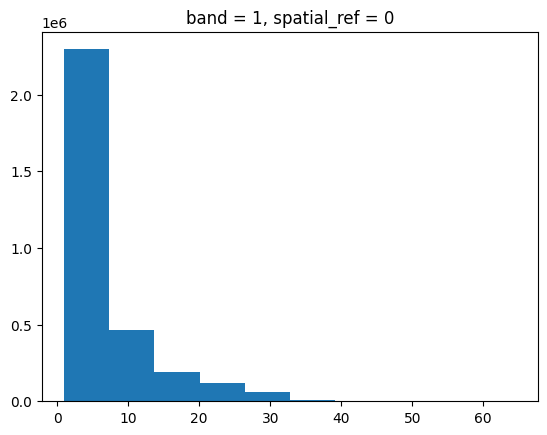

In [10]:
#generate histogram of pixels for full scence
#..store histogram info
h_landsat = landsat_emitCRS.plot.hist()

# Creating spectra plots for each tree cover class
### Includes means and standard deviations.

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


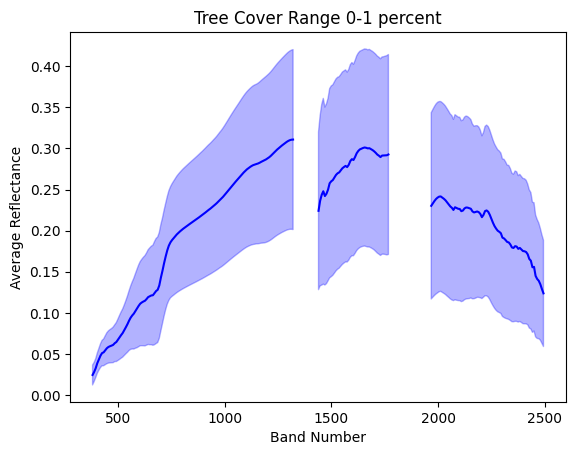

In [15]:
#for zero
mask_TC = landsat_emitCRS.where(landsat_emitCRS >= 0, 1, 0).where(landsat_emitCRS < 1, 1, 0)
band_numbers = ds['wavelengths'].data
emit_masked_TC = [None] * len(band_numbers)
for i in range(len(band_numbers)):
    #print status every 10 bands to check if running
    if (i % 10) == 0:
        print(i)
    data = ds['reflectance'].sel(wavelengths=band_numbers[i])
    emit_masked_TC[i] = data.where(data > 0).data * mask_TC
averages = [None] * len(band_numbers)
stds = [None] * len(band_numbers)
for i in range(len(band_numbers)):
    averages[i] = emit_masked_TC[i].mean()
    stds[i] = emit_masked_TC[i].std()
averages_x = xr.DataArray(data = averages)
stds_x = xr.DataArray(data = stds)
plt.figure()
plt.plot(band_numbers, averages_x, c='blue')
plt.fill_between(band_numbers, averages_x-stds_x, averages_x+stds_x, color='blue', alpha=.3)
plt.xlabel("Band Number")
plt.ylabel("Average Reflectance")
plt.title("Tree Cover Range 0-1 percent")
plt.show()

1
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


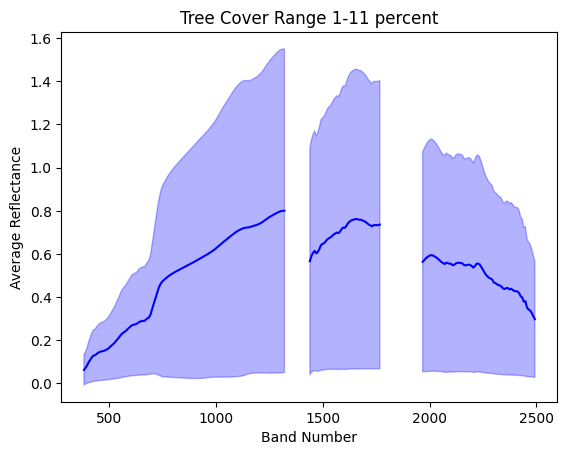

11
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


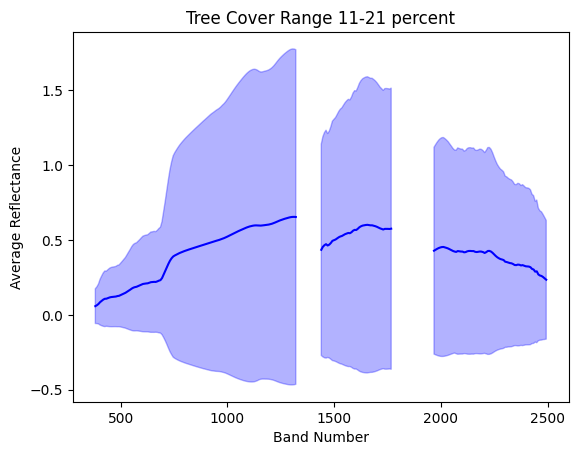

21
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


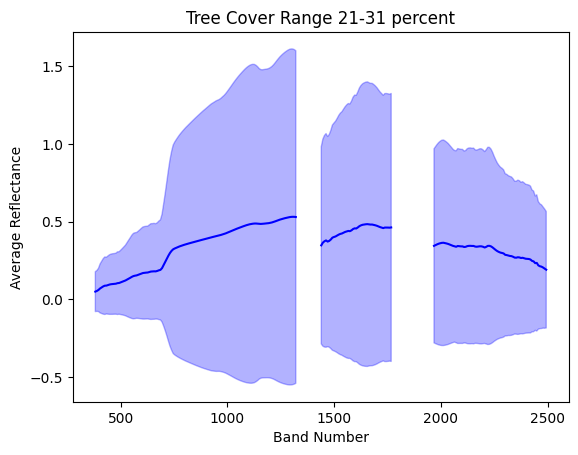

31
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


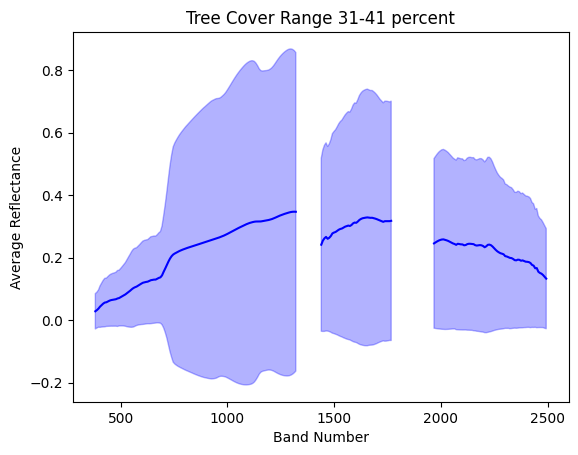

41
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


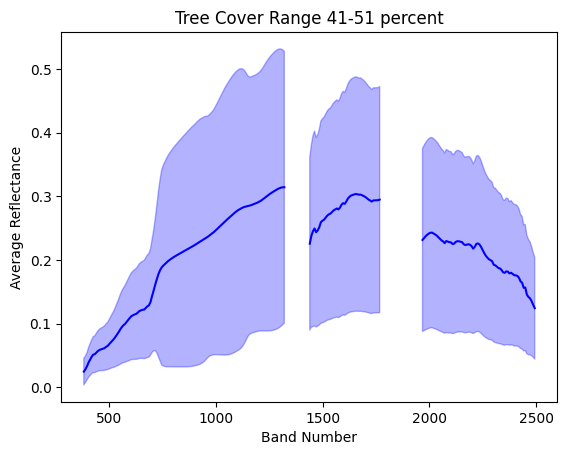

51
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


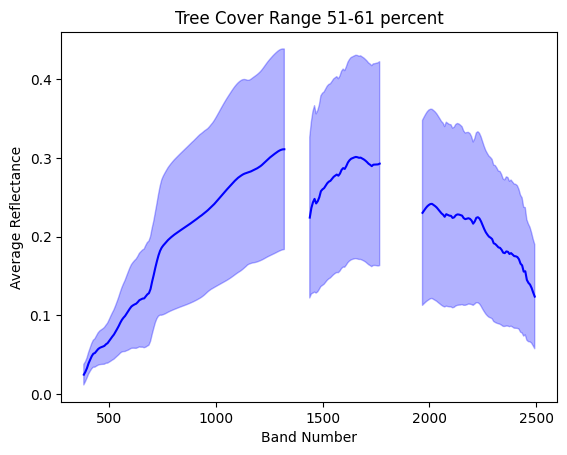

61
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


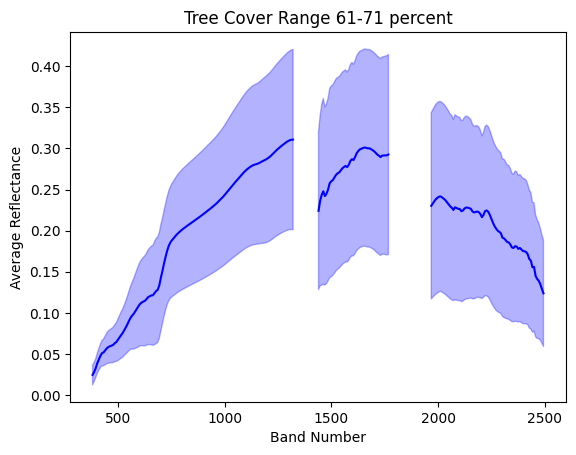

71
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


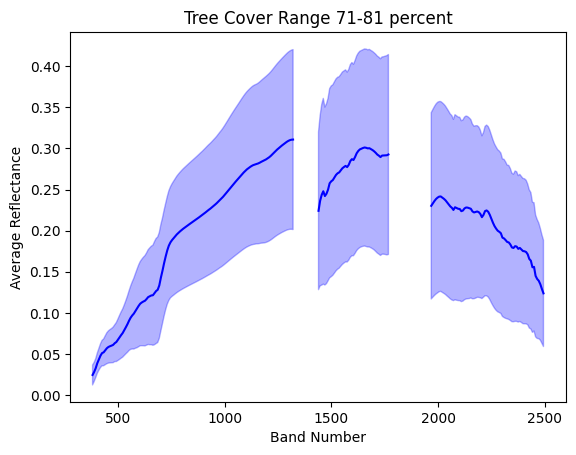

81
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


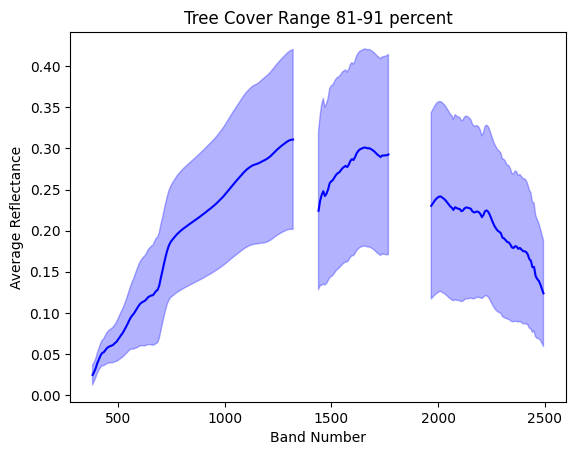

91
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


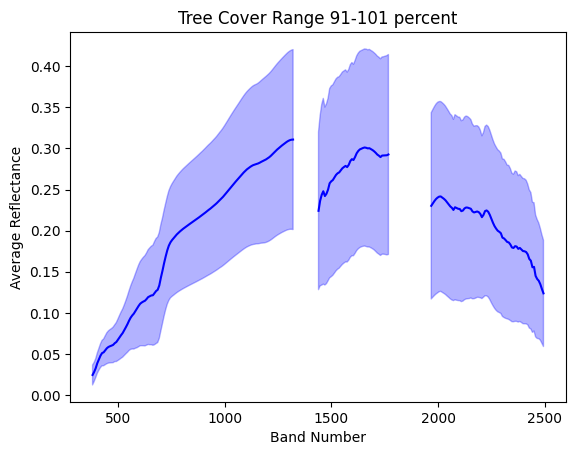

In [16]:
for x in range (1,101,10):
    print(x)
    #form mask for the specified level of tree cover
    mask_TC = landsat_emitCRS.where(landsat_emitCRS >= x, 1, 0).where(landsat_emitCRS < x+10, 1, 0)
    band_numbers = ds['wavelengths'].data
    emit_masked_TC = [None] * len(band_numbers)
    averages = [None] * len(band_numbers)
    stds = [None] * len(band_numbers)
    for i in range(len(band_numbers)):
        #print status every 10 bands to check if running
        if (i % 10) == 0:
            print(i)
        data = ds['reflectance'].sel(wavelengths=band_numbers[i])
        emit_masked_TC[i] = data.where(data > 0).data * mask_TC
        averages[i] = emit_masked_TC[i].mean()
        stds[i] = emit_masked_TC[i].std()
    averages_x = xr.DataArray(data = averages)
    stds_x = xr.DataArray(data = stds)
    plt.figure()
    plt.plot(band_numbers, averages_x, c='blue')
    plt.fill_between(band_numbers, averages_x-stds_x, averages_x+stds_x, color='blue', alpha=.3)
    plt.xlabel("Band Number")
    plt.ylabel("Average Reflectance")
    plt.title("Tree Cover Range "+str(x)+"-"+str(x+10)+" percent")
    plt.show()